In [1]:
#!pip install qiskit --upgrade
!pip install qiskit[visualization] --quiet

In [2]:
import math
import qiskit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit_aer.backends import AerSimulator
from qiskit.quantum_info import Statevector, random_statevector, Pauli, SparsePauliOp
from qiskit.visualization import plot_bloch_multivector
from qiskit.primitives import Estimator

from seaborn import *
from qiskit_aer import AerSimulator
from qiskit_experiments.library import StateTomography


# Exercise 3

In [3]:
def teleport(StateVector):

    circ_q = qiskit.QuantumRegister(3, name='q')
    circ_c = qiskit.ClassicalRegister(1, name='c')
    circ = qiskit.QuantumCircuit(circ_q, circ_c)
    circ.initialize(StateVector, circ_q[0])
    
    circ.h(circ_q[2])
    circ.cx(circ_q[2], circ_q[1])
    
    circ.barrier()
    circ.cx(circ_q[0], circ_q[1])
    circ.h(circ_q[0])
    
    circ.barrier()
    circ.measure(circ_q[1], circ_c)
    circ.x(circ_q[2]).c_if(circ_c, 1)
    
    circ.measure(circ_q[0], circ_c)
    circ.z(circ_q[2]).c_if(circ_c, 1)
    
    return circ

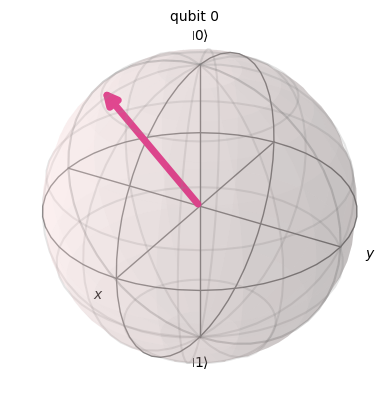

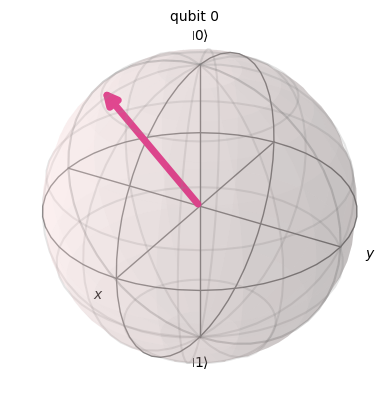

In [4]:
rand = random_statevector(2)
plot_bloch_multivector(rand)

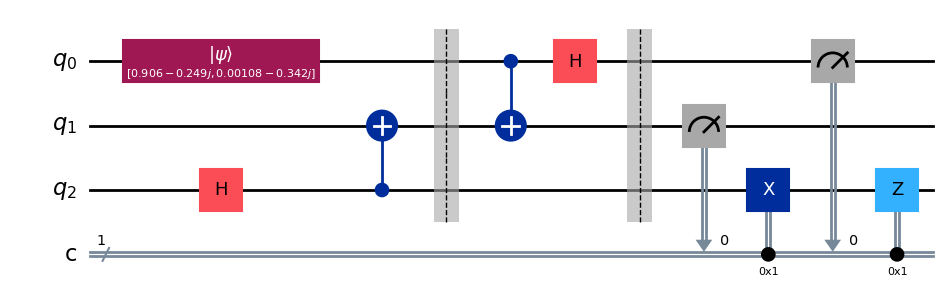

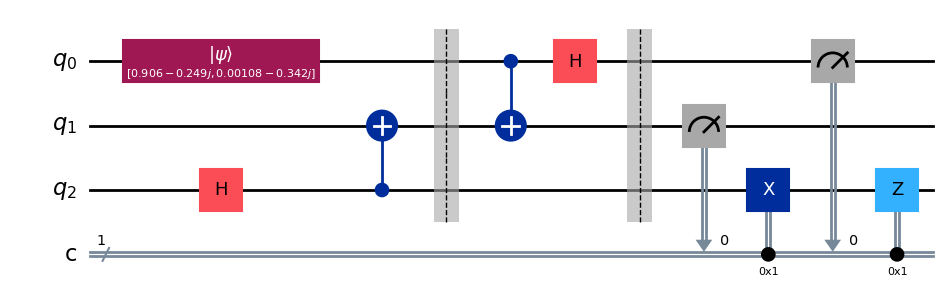

In [5]:
teleported_circuit = teleport(rand)

teleported_circuit.draw('mpl')

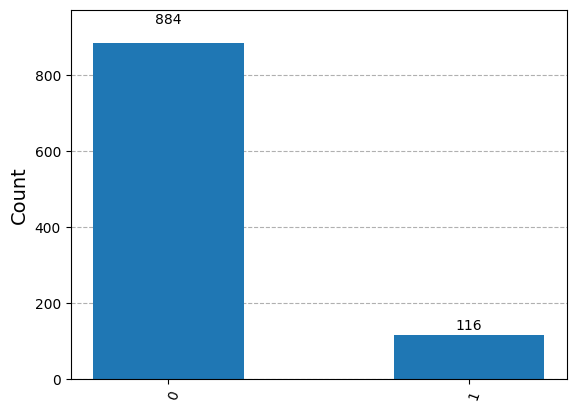

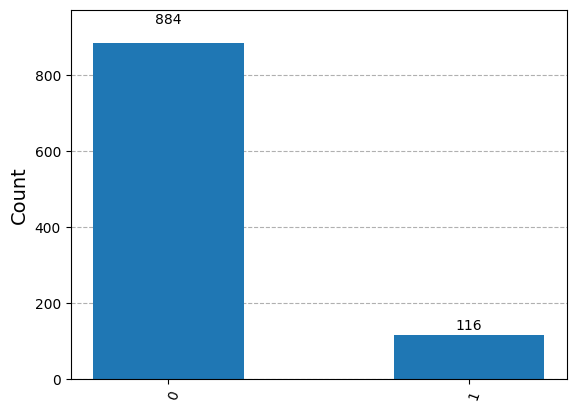

In [6]:
sim = AerSimulator(method="statevector")

N_shots = 1000  # number of measurements

teleported_circuit.save_statevector()  # save statevector at the end of the circuit
teleported_state = sim.run(teleported_circuit).result().get_statevector()

teleported_circuit.measure(2, 0)

result = sim.run(teleported_circuit, shots=N_shots).result()
counts = result.get_counts(teleported_circuit)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

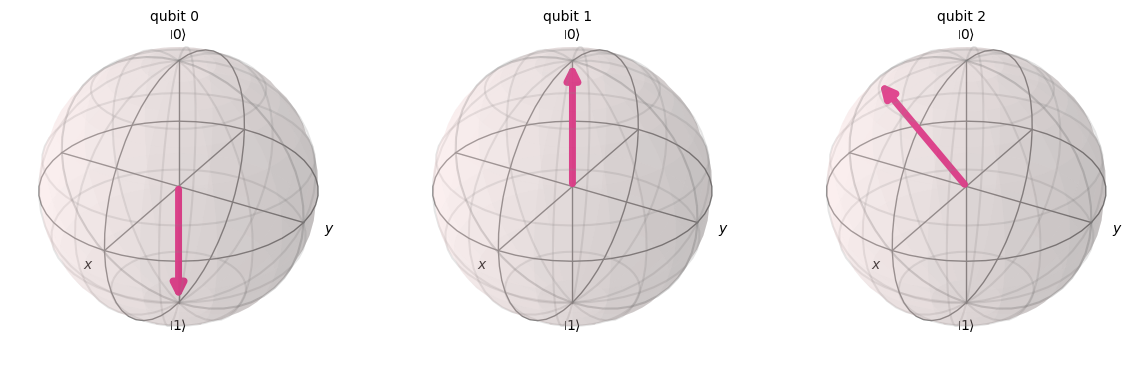

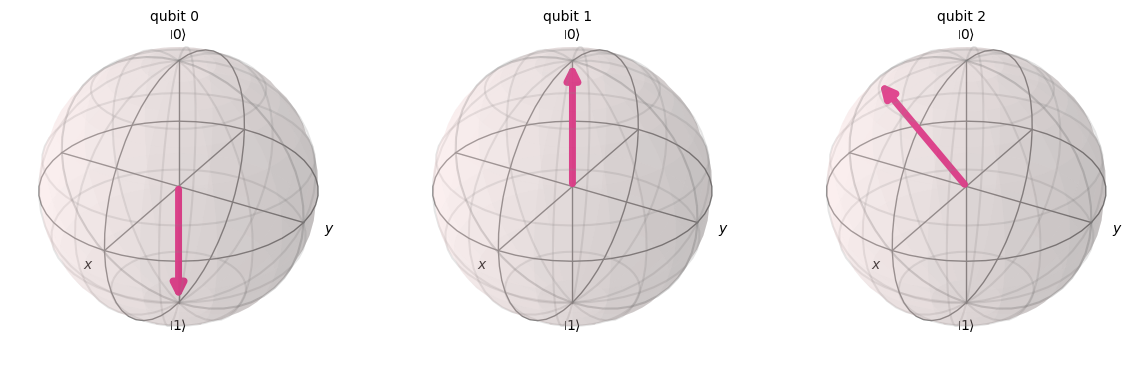

In [7]:
plot_bloch_multivector(teleported_state)

In [1]:
import qiskit
from qiskit_aer.backends import AerSimulator
import numpy as np
import matplotlib.pyplot as plt


## Exercise 5

In [25]:
def time_evolve(t, dt, w, w0, w1,bit):
    q = qiskit.QuantumRegister(1, name = 'q')
    c = qiskit.ClassicalRegister(1, name = 'c')
    circ = qiskit.QuantumCircuit(q,c)
    
    N = int(t/dt)

    for i in range(N):
         circ.rx(w1*dt*np.cos(w*i*dt)*2,0)
         circ.rz(-w0*dt,0)

    sim = AerSimulator()
    N_shots = 400
    
    circ.measure(q,c)

    result =  sim.run(circ, shots=N_shots).result()
    counts = result.get_counts(circ)


    """ try:
          pass
     except KeyError:
          pass """
    if bit in counts:
     return counts[bit]/N_shots
    else:
       return 0



In [26]:
def population(w,w0,w1,t):
    delta = w-w0
    return w1**2*np.sin(np.sqrt(w1**2+delta**2)*t/2)**2/(w1**2+delta**2)

Measure the population of state |1⟩ using 400 shots for:
(a) different t. You may use the following parameters, w1 = 2, w0 =
25, w = 25.5 for t ∈ [0, 4]. And fix the time step to be δt = 0.05

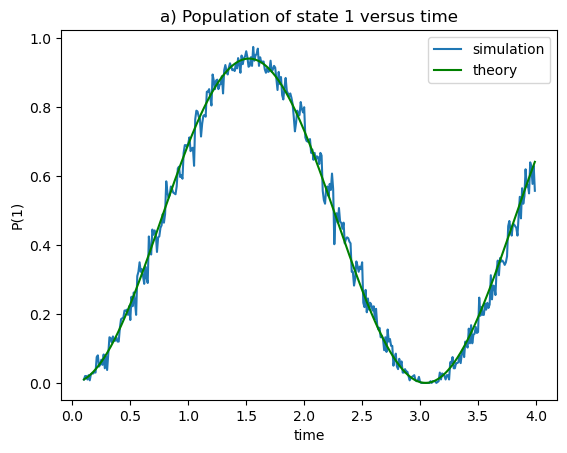

In [27]:
t = np.arange(0.1,4,0.01)
w1 = 2
w0 =25
w = 25.5
dt = 0.05
Pa = []
Pc = []
for tt in t:
    #print(tt)
    Pa.append(time_evolve(tt,dt,w,w0,w1,'1'))
    Pc.append(time_evolve(tt,dt,2,2,2,'1'))


plt.plot(t,Pa, label = 'simulation')
plt.plot(t, population(w,w0,w1,t), label= 'theory', color = "green")
plt.xlabel('time')
plt.ylabel('P(1)')
plt.title('a) Population of state 1 versus time')
plt.legend()
plt.savefig("a.png")

(c) Try also ω = ω0 = ω1 = 2. Compare to the analytic solution and
explain your findings.

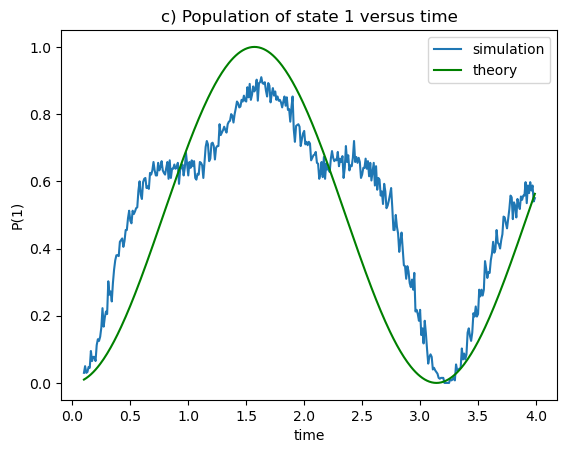

In [28]:
plt.plot(t,Pc, label = 'simulation')
plt.plot(t, population(2,2,2,t), label= 'theory', color = "green")
plt.xlabel('time')
plt.ylabel('P(1)')
plt.title('c) Population of state 1 versus time')
plt.legend()
plt.savefig("c.png")

The reason why the simulation is not compatible with the theory is because given these frequencies the rotating wave approximation is not optimal, for it to work well we need w0, w >> w1 (check)

(b) different detunings ∆ (Vary ω ∈ [10, 40], at t = π/ω1)
Plot your measurement results against the solution from Exercise 4.

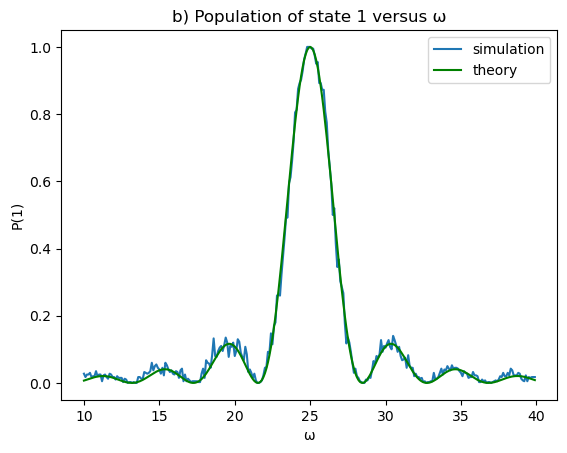

In [7]:
w = np.arange(10,40,0.1)
Pb = []
t = np.pi/w1
for ww in w:
    Pb.append(time_evolve(t,dt,ww,w0,w1,'1'))

plt.plot(w,Pb, label = 'simulation')
plt.plot(w, population(w,w0,w1,t), label= 'theory', color = "green")
plt.xlabel('ω')
plt.ylabel('P(1)')
plt.legend()
plt.title('b) Population of state 1 versus ω')
plt.savefig('b.png')

## Exercise 6

Add noise to the simulator AerSimulator() to perform
the time evolution in Exercise 5 in a noisy environment. The GAD can
be implemented by
amplitude damping error(gamma, p).
Use the method add all qubit quantum error() to specify the noise
so that Qiskit will automatically implement a GAD after every single-
qubit gate in the circuit. You may use the values p = 0.1 and γ = 0.02
and the same parameters from 5(a), and plot your noisy result against
what you obtained from Exercise 5(a). For a large enough time span,
you should observe a decay time scale for |1⟩ signal (sometimes called
T1).
Run the same measurements with a smaller time step δt = 0.01 and
the same time span, what do you observe? Explain your finding.

In [8]:
from qiskit_aer.noise import NoiseModel, amplitude_damping_error

In [9]:
def noisy_time_evolve(t, dt, w, w0, w1, p, gamma, bit):
    q = qiskit.QuantumRegister(1, name = 'q')
    c = qiskit.ClassicalRegister(1, name = 'c')
    circ = qiskit.QuantumCircuit(q,c)

    noise = NoiseModel()
    error = amplitude_damping_error(gamma, p)
    noise.add_all_qubit_quantum_error(error, ['rx', 'rz'])
    #noise.add_all_qubit_quantum_error(error, ['rz'])

    
    N = int(t/dt)

    for i in range(N):
         circ.rx(w1*dt*np.cos(w*i*dt)*2,0)
         circ.rz(-w0*dt,0)

    sim = AerSimulator(noise_model = noise)
    N_shots = 400
    
    circ.measure(q,c)

    result =  sim.run(circ, shots=N_shots).result()
    counts = result.get_counts(circ)


    """ try:
          pass
     except KeyError:
          pass """
    if bit in counts:
     return counts[bit]/N_shots
    else:
       return 0

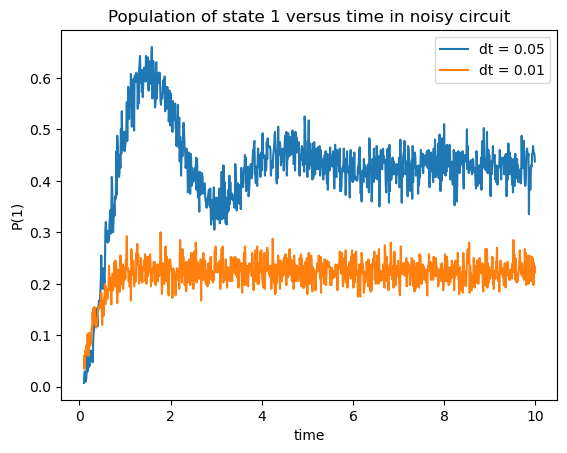

In [10]:
import pickle

t = np.arange(0.1,10,0.01)
w1 = 2
w0 =25
w = 25.5
dt = 0.05
dtnew = 0.01
p = 0.1
gamma = 0.02
P6 = []
P6new = []
P5a = []
for tt in t:
    #print(tt)
    P5a.append(time_evolve(tt,dt,w,w0,w1,'1'))
    P6.append(noisy_time_evolve(tt,dt,w,w0,w1,p,gamma,'1'))
    P6new.append(noisy_time_evolve(tt,dtnew,w,w0,w1,p,gamma,'1'))

# Save the list to a file
with open('P6.pkl', 'wb') as file:
    pickle.dump(P6, file)

with open('P6new.pkl', 'wb') as file:
    pickle.dump(P6new, file)

""" Load the list from the file
with open('my_list.pkl', 'rb') as file:
    loaded_list = pickle.load(file)
"""


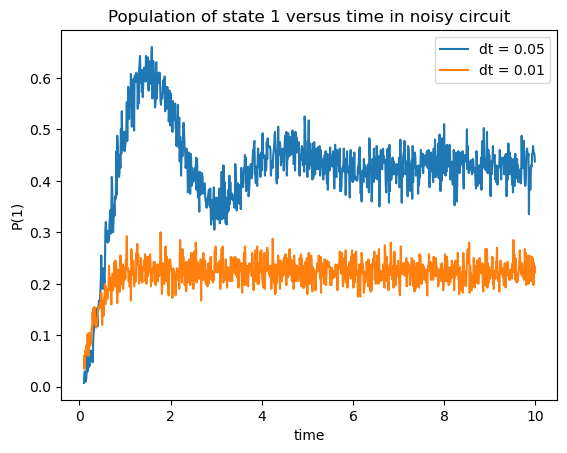

In [23]:
t = np.arange(0.1,10,0.01)   
plt.plot(t,P6, label = 'dt = 0.05')
plt.plot(t,P6new, label = 'dt = 0.01')
plt.xlabel('time')
plt.ylabel('P(1)')
plt.legend()
plt.title('Population of state 1 versus time in noisy circuit')
plt.savefig("ex6b.png")

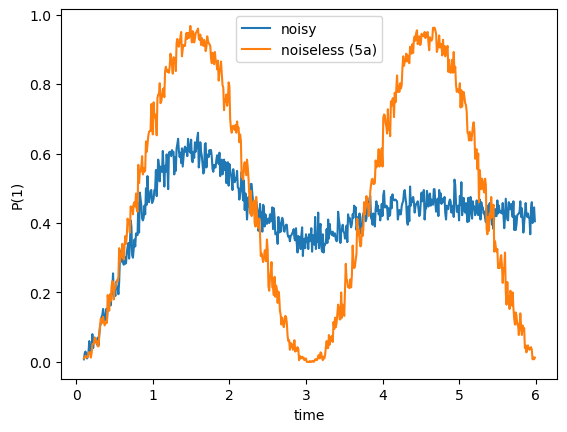

In [22]:
t = np.arange(0.1,6,0.01)   
plt.plot(t,P6[:len(t)], label = 'noisy')
plt.plot(t,P5a[:len(t)], label = 'noiseless (5a)')
plt.xlabel('time')
plt.ylabel('P(1)')
plt.legend()
plt.savefig("ex6a.png")

In the case of smaller dt we insert more noise in the time evolution, because there are more gates so the probability of error is higher -> it decays more quickly

## Ex 7)

Repeat 5(a) using the fake machine backend
from qiskit.providers.fake provider import Fake5QV1
for time t ∈ [0, 10]. This performs the experiment using realistic noise
models from the device Vigo. Compare your result to Exercise 6.
In this practical we will not attempt to mitigate such errors, in fact, error mitigation for such type is in general very subtle for more than a few qubits. It is
however important to understand how these errors can affect your measurement
result if your program is run on an actual device!

In [13]:
from qiskit.providers.fake_provider import Fake5QV1

def realnoisy_time_evolve(t, dt, w, w0, w1, p, gamma, bit):
    q = qiskit.QuantumRegister(1, name = 'q')
    c = qiskit.ClassicalRegister(1, name = 'c')
    circ = qiskit.QuantumCircuit(q,c)
    
    N = int(t/dt)

    for i in range(N):
         circ.rx(w1*dt*np.cos(w*i*dt)*2,0)
         circ.rz(-w0*dt,0)

    fake = Fake5QV1()
    noise = NoiseModel.from_backend(fake)
    sim = AerSimulator(noise_model = noise)
    N_shots = 400
    
    circ.measure(q,c)

    result =  sim.run(circ, shots=N_shots).result()
    counts = result.get_counts(circ)


    """ try:
          pass
     except KeyError:
          pass """
    if bit in counts:
     return counts[bit]/N_shots
    else:
       return 0

Text(0, 0.5, 'Population of |1>')

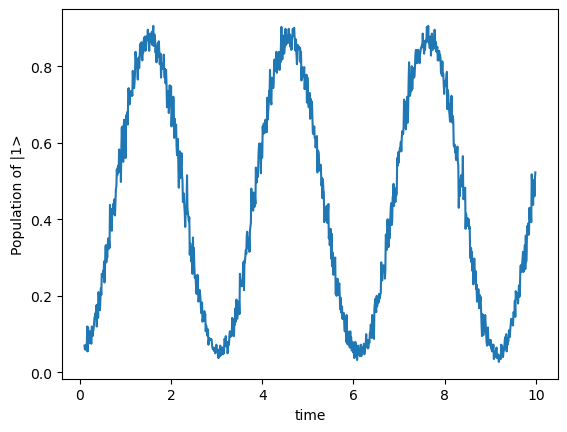

In [14]:
w1 = 2
w0 =25
w = 25.5
dt = 0.05
dtnew = 0.01
p = 0.1
gamma = 0.02

t = np.arange(0.1,10,0.01)
P7 = []
for tt in t:
    #print(tt)
    P7.append(realnoisy_time_evolve(tt,dt,w,w0,w1,p,gamma,'1'))

plt.plot(t,P7)
plt.xlabel('time')
plt.ylabel('Population of |1>')

In [15]:
with open('P7.pkl', 'wb') as file:
    pickle.dump(P7, file)

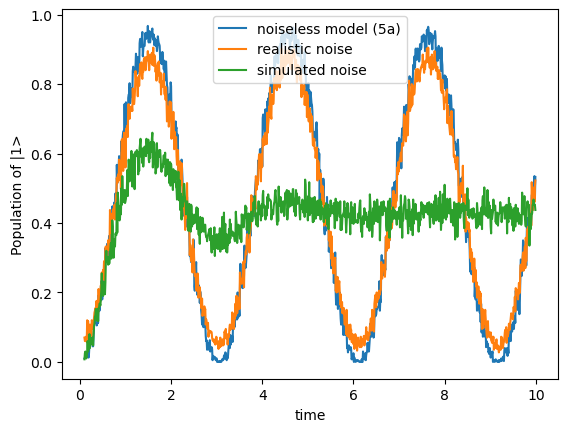

In [19]:
#Pa = []
#for tt in t:
#    #print(tt)
#    Pa.append(time_evolve(tt,dt,w,w0,w1,'1'))

#plt.scatter(t,P5a, label = 'noiseless', s = 6)
#plt.scatter(t,P7, label = 'noisy 7', s = 6)
#plt.scatter(t,P6, label = "noisy 6", s = 6)

plt.plot(t,P5a, label = 'noiseless model (5a)')
plt.plot(t,P7, label = 'realistic noise')
plt.plot(t,P6, label = 'simulated noise')

plt.xlabel('time')
plt.ylabel('Population of |1>')
plt.legend()
plt.savefig("ex7new.png")

# Exercise 8 and 9

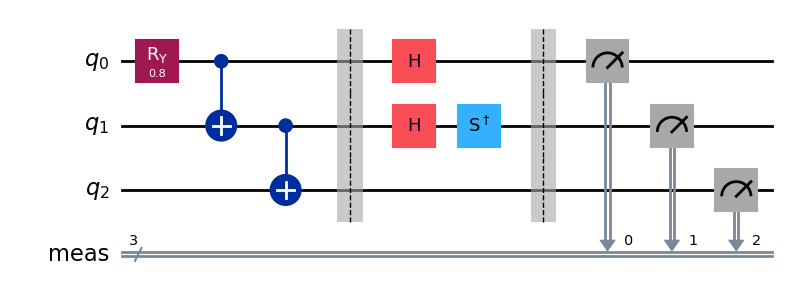

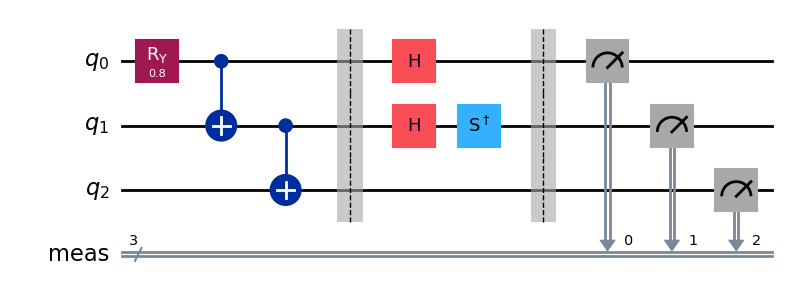

In [16]:
from qiskit.circuit import QuantumCircuit
 
# create a circuit, where we would like to measure
# q0 in the X basis, q1 in the Y basis and q2 in the Z basis
circuit = QuantumCircuit(3)
circuit.ry(0.8, 0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.barrier()
 
# diagonalize X with the Hadamard gate 
circuit.h(0)
 
# diagonalize Y with Hadamard as S^\dagger
circuit.h(1)
circuit.sdg(1)
 
# the Z basis is the default, no action required here
 
# measure all qubits
circuit.measure_all()
circuit.draw("mpl")

In [17]:
from qiskit import *
from qiskit.visualization import plot_state_city

In [18]:
qc = QuantumCircuit(1)
qc.h(0)
qc.t(0)
qc.measure_all()

# Define the measurement circuits in the X and Y bases
qc_x = QuantumCircuit(1)
qc_x.h(0)
qc_x.t(0)
qc_x.h(0)
qc_x.measure_all()


qc_y = QuantumCircuit(1)
qc_y.h(0)
qc_y.t(0)
qc_y.sdg(0)
qc_y.h(0)
qc_y.measure_all()

In [19]:
print(qc,qc_x,qc_y)

        ┌───┐┌───┐ ░ ┌─┐
     q: ┤ H ├┤ T ├─░─┤M├
        └───┘└───┘ ░ └╥┘
meas: 1/══════════════╩═
                      0          ┌───┐┌───┐┌───┐ ░ ┌─┐
     q: ┤ H ├┤ T ├┤ H ├─░─┤M├
        └───┘└───┘└───┘ ░ └╥┘
meas: 1/═══════════════════╩═
                           0          ┌───┐┌───┐┌─────┐┌───┐ ░ ┌─┐
     q: ┤ H ├┤ T ├┤ Sdg ├┤ H ├─░─┤M├
        └───┘└───┘└─────┘└───┘ ░ └╥┘
meas: 1/══════════════════════════╩═
                                  0 


{'1': 519, '0': 481}
{'1': 147, '0': 853}
{'1': 131, '0': 869}


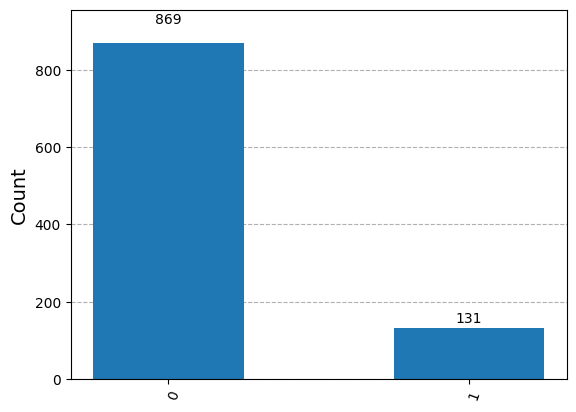

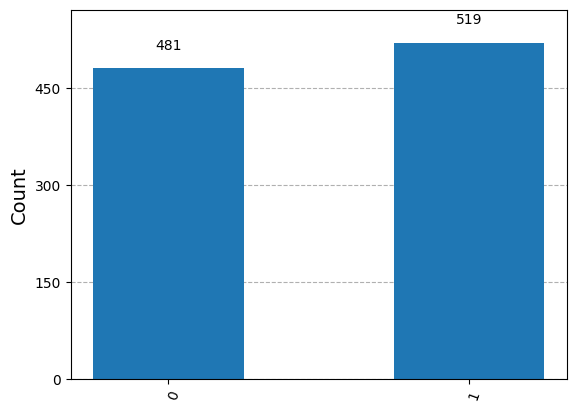

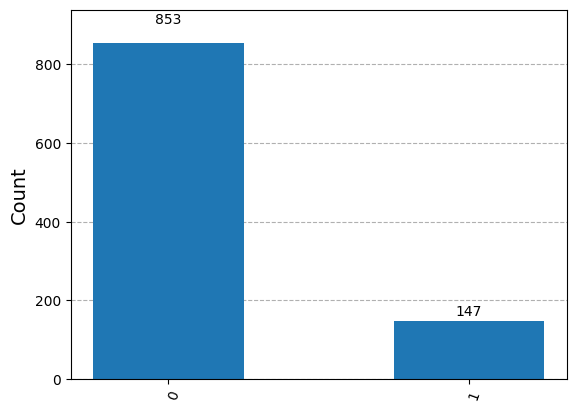

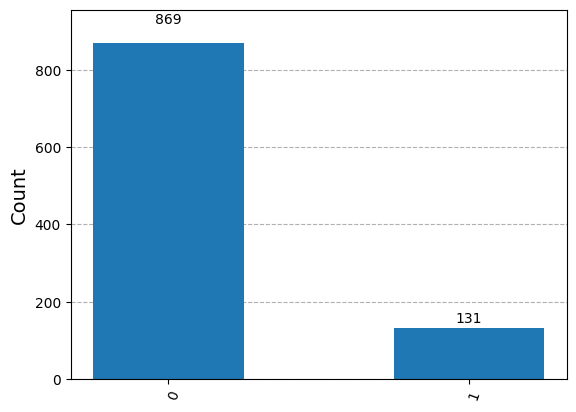

In [20]:
sim = AerSimulator()

N_shots = 1000  # number of measurements

result = sim.run(qc, shots=N_shots).result()
counts = result.get_counts(qc)
print(counts)

from qiskit.visualization import plot_histogram
plot_histogram(counts)


sim = AerSimulator()

N_shots = 1000  # number of measurements

result = sim.run(qc_x, shots=N_shots).result()
counts_x = result.get_counts(qc_x)
print(counts_x)

from qiskit.visualization import plot_histogram
plot_histogram(counts_x)



sim = AerSimulator()

N_shots = 1000  # number of measurements

result = sim.run(qc_y, shots=N_shots).result()
counts_y = result.get_counts(qc_y)
print(counts_y)

from qiskit.visualization import plot_histogram
plot_histogram(counts_y)

In [21]:
prob_0 = counts.get('0', 0) / N_shots
prob_1 = counts.get('1', 0) / N_shots
 
expec_z = prob_0 - prob_1

In [22]:
# Extract the probabilities from the counts in the X basis
prob_0_x = counts_x.get('0', 0) / N_shots
prob_1_x = counts_x.get('1', 0) / N_shots
expec_x = prob_0_x - prob_1_x

# Extract the probabilities from the counts in the Y basis
prob_0_y = counts_y.get('0', 0) / N_shots
prob_1_y = counts_y.get('1', 0) / N_shots
expec_y = prob_0_y - prob_1_y

In [23]:
print(expec_x,
expec_y,
expec_z)

0.706 0.738 -0.038000000000000034


In [24]:
c_0 = 0.5
c_1 = (expec_z) * 0.5
c_2 = (expec_x) * 0.5
c_3 = (expec_y) * 0.5

print(c_1,c_2,c_3)

-0.019000000000000017 0.353 0.369


In [25]:
s0 = np.matrix([[1,0],[0,1]])
s1 = np.matrix([[0,1],[1,0]])
s2 = np.matrix([[0,-1j],[1j,0]])
s3 = np.matrix([[1,0],[0,-1]])

density_matrix = s0 * c_0 + s1 * c_2 + s2 * c_3 + s3 * c_1
print(density_matrix)

[[0.481+0.j    0.353-0.369j]
 [0.353+0.369j 0.519+0.j   ]]


[0.69354164+0.j 0.72041655+0.j]
Density Matrix:


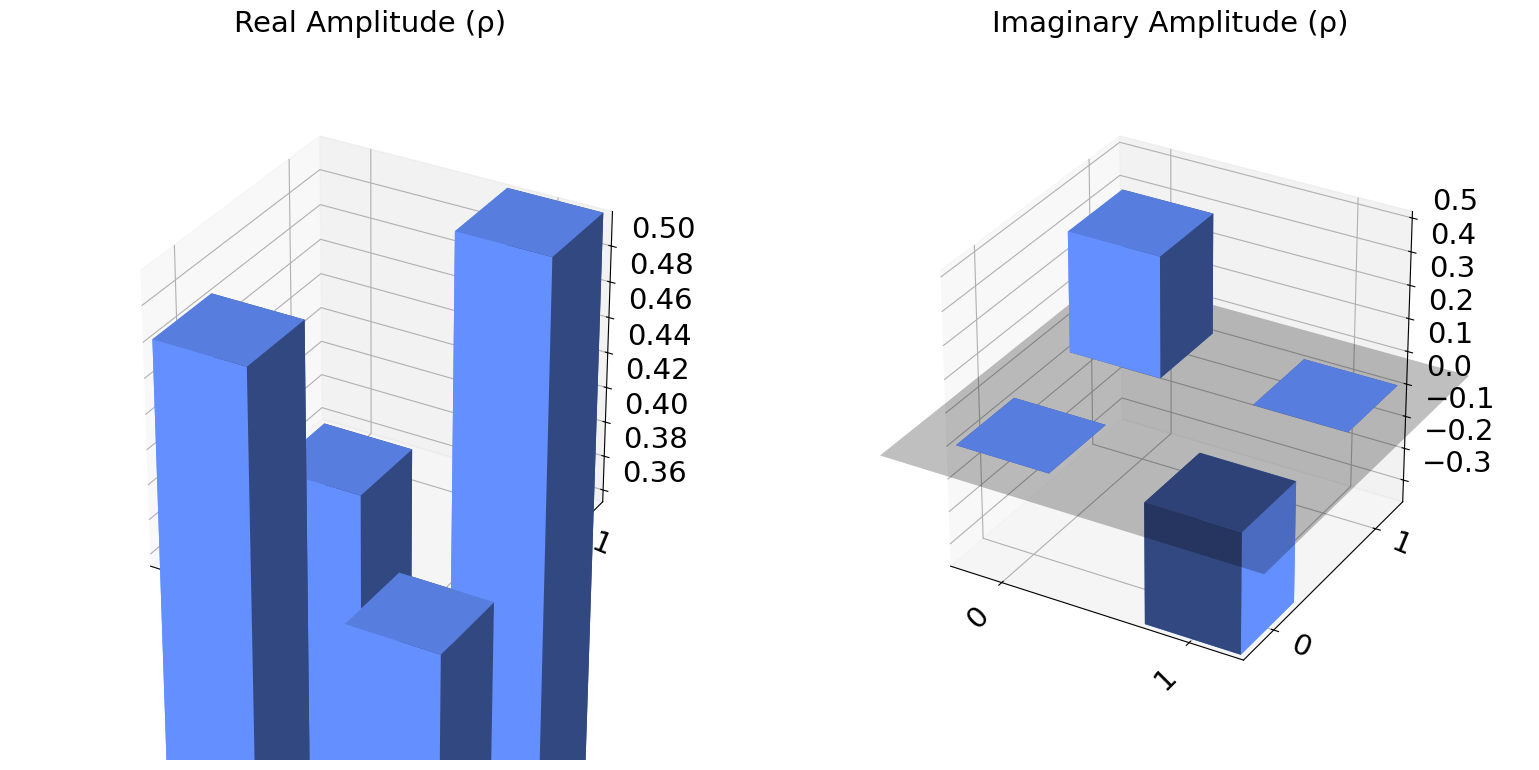

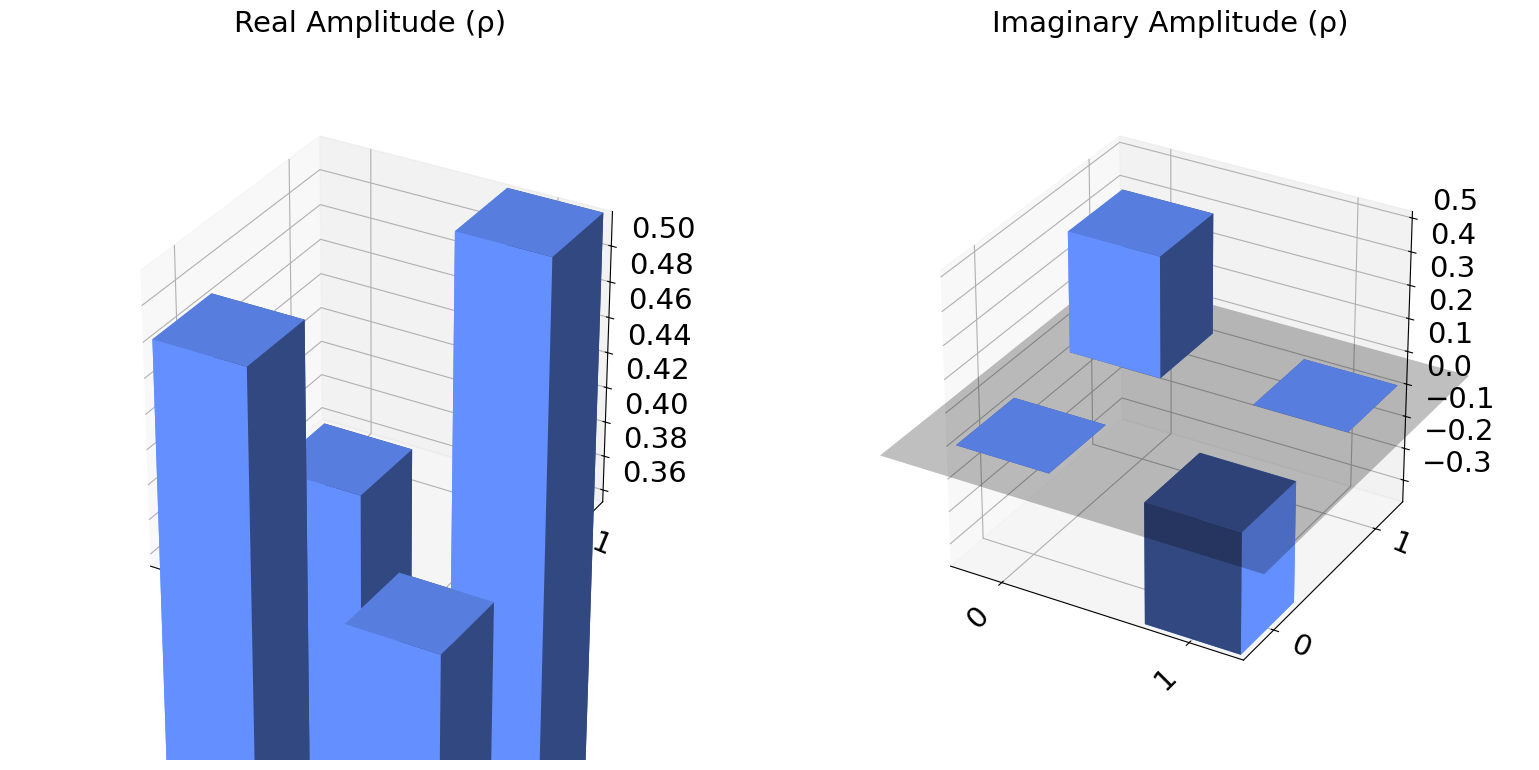

In [26]:
state_vector = np.sqrt(np.diag(density_matrix))
print(state_vector)
print("Density Matrix:")
plot_state_city(density_matrix)

In [27]:
!pip install qiskit_experiments
from qiskit_experiments.library import StateTomography

In [28]:
qc = QuantumCircuit(1)
qc.h(0)
qc.t(0)
st = StateTomography(qc)

In [29]:
sim = AerSimulator()
result = st.run(sim)
print(result.analysis_results('state'))

AnalysisResult
- name: state
- value: DensityMatrix([[0.48553627+0.00000000e+00j, 0.35580783-3.50986589e-01j],
               [0.35580783+3.50986589e-01j, 0.51446373-1.19017340e-17j]],
              dims=(2,))
- quality: unknown
- extra: <9 items>
- device_components: ['Q0']
- verified: False


# Exercise 10

In [2]:
def time_evolve(t, dt, w, w0, w1):
    q = qiskit.QuantumRegister(1, name = 'q')
    c = qiskit.ClassicalRegister(1, name = 'c')
    circ = qiskit.QuantumCircuit(q,c)
    
    N = int(t/dt)

    for i in range(N):
         circ.rx(w1*dt*np.cos(w*i*dt)*2,0)
         circ.rz(-w0*dt,0)
    st1 = StateTomography(circ)
    sim = AerSimulator()
    N_shots = 10000
    
    #circ.measure(q,c)

    result =  st1.run(sim, shots=N_shots)
    #counts = result.get_counts(circ)
    return np.array(result.analysis_results('state').value)


    """ try:
          pass
     except KeyError:
          pass 
    if bit in counts:
     return counts[bit]/N_shots
    else:
       return 0 """

In [3]:
def beta(t,w,w0,w1):
    delta = w-w0
    omega = np.sqrt(w1**2 + delta**2)
    return w1*np.sin(omega*t/2)/omega

#-1j*w1*np.sin(omega*t/2)*np.exp(-1j*w*t)/omega

def alpha(t,w,w0,w1):
    delta = w-w0
    omega = np.sqrt(w1**2 + delta**2)
    return (-1j*delta*np.sin(omega*t/2)/omega + np.cos(omega*t/2))*np.exp(1j*w*t)

def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

In [4]:
t = np.arange(0.05,2,0.02)
w1 = 2
w0 =25
w = 25.5
dt = 0.02
A = []
B = []
delta = w-w0
omega = np.sqrt(w1**2 + delta**2)
for tt in t:
    rho = time_evolve(tt,dt,w,w0,w1)
    b = np.sqrt(np.real(rho[1,1]))*sign(np.sin(omega*tt/2))
    B.append(b)
    A.append(rho[0,1]/(1j*b))

#other approach
"""for tt in t:
    rho = time_evolve(tt,dt,w,w0,w1)
    eigenvalues, eigenvectors =  np.linalg.eigh(rho)
    max_eigenvalue_index = np.argmax(eigenvalues)
    pure_state = eigenvectors[:, max_eigenvalue_index]
    #print(pure_state)
    A.append(pure_state[0])
    B.append(pure_state[1])"""


'for tt in t:\n    rho = time_evolve(tt,dt,w,w0,w1)\n    eigenvalues, eigenvectors =  np.linalg.eigh(rho)\n    max_eigenvalue_index = np.argmax(eigenvalues)\n    pure_state = eigenvectors[:, max_eigenvalue_index]\n    #print(pure_state)\n    A.append(pure_state[0])\n    B.append(pure_state[1])'

/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


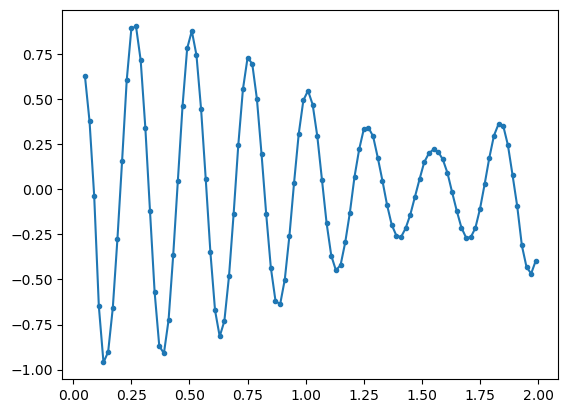

In [5]:
plt.plot(t,A,'.-')

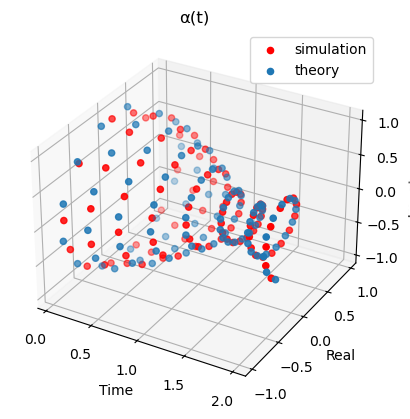

In [10]:
Areal = np.real(A)
Aim = np.imag(A)
alphareal = np.real(alpha(t,w,w0,w1))
alphaim = np.imag(alpha(t,w,w0,w1))
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(t,Areal,Aim, color = "red", label='simulation')
ax.scatter(t,alphareal,alphaim, label = 'theory')
ax.set_title('α(t)')
ax.set_xlabel('Time')
ax.set_ylabel('Real')
ax.set_zlabel('Imaginary')
ax.legend()

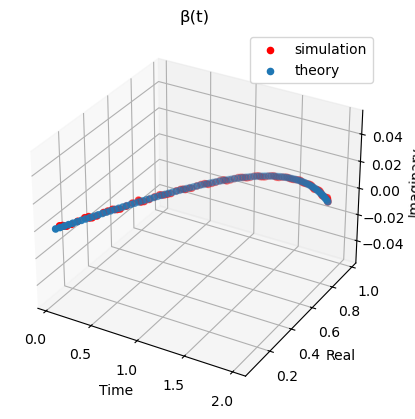

In [11]:
#simulation
Breal = np.real(B) 
Bim = np.imag(B)
#theory
betareal = np.real(beta(t,w,w0,w1))
betaim = np.imag(beta(t,w,w0,w1))
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(t,Breal,Bim, color = "red", label = 'simulation')
ax.scatter(t,betareal,betaim, label = 'theory')
ax.set_title('β(t)')
ax.set_xlabel('Time')
ax.set_ylabel('Real')
ax.set_zlabel('Imaginary')
ax.legend()

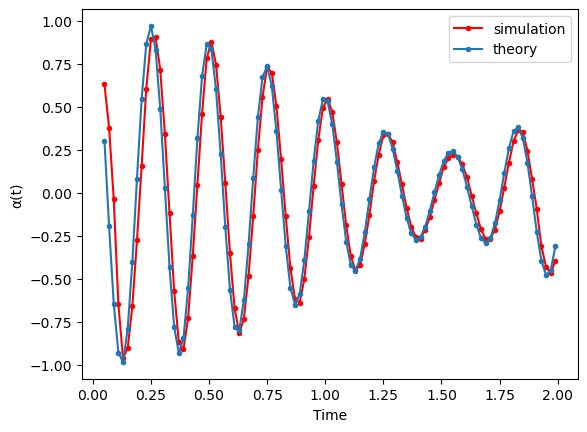

In [8]:
plt.plot(t,Areal, '.-', color = "red", label = 'simulation')
plt.plot(t,alphareal, '.-', label = 'theory')
plt.xlabel("Time")
plt.ylabel('α(t)')
plt.legend()


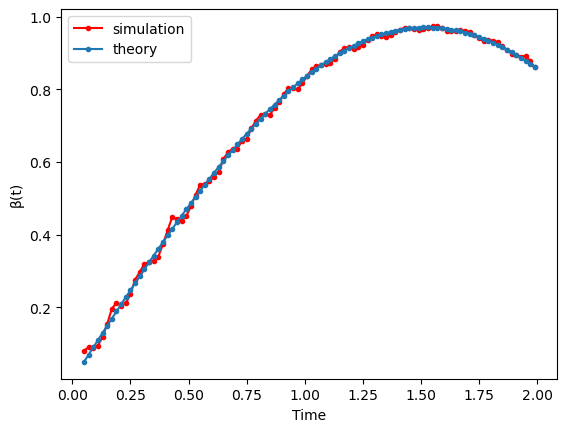

In [9]:
plt.plot(t,Breal, '.-', color = "red", label = 'simulation')
plt.plot(t,betareal, '.-', label = 'theory')
plt.xlabel("Time")
plt.ylabel('β(t)')
plt.legend()

# Exercise 11

In [14]:
def parametrized_circuit(a, b):

    circ_q = qiskit.QuantumRegister(2, name='q')
    circ = qiskit.QuantumCircuit(circ_q)

    circ.h(1)
    circ.rzz(-2*b, circ_q[0], circ_q[1])
    circ.h(1)
    
    circ.barrier()
    circ.h(0)
    circ.rzz(-2*b, circ_q[0], circ_q[1])
    circ.h(0)
    
    circ.barrier()
    circ.rz(-2*a, circ_q[0])
    circ.rz(-2*a, circ_q[1])
 
    return circ


# Exercise 12

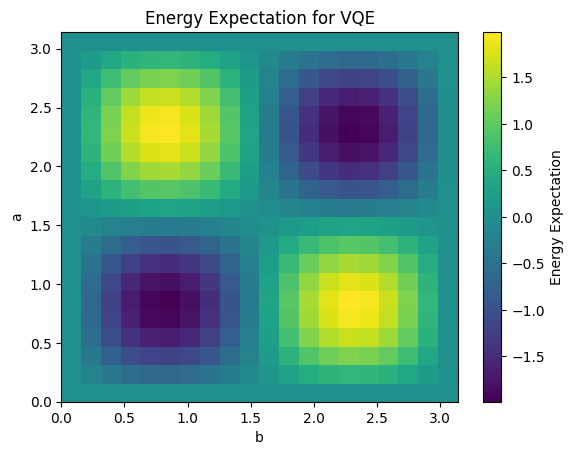

Minimum energy: -1.9863613034027208 at a = 0.8267349088394192, b = 0.8267349088394192


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

H = SparsePauliOp.from_list([("XZ", -1), ("ZX", -1)])

# Prepare the grid search parameters
nmbr_points = 20
a_array = np.linspace(0, np.pi, nmbr_points)
b_array = np.linspace(0, np.pi, nmbr_points)
expectation_value = np.zeros((nmbr_points, nmbr_points))

# Backend setup
backend = AerSimulator()

# Estimator without noise model
estimator = Estimator()

# Evaluate the energy expectation for each parameter set without noise
for a_id, a_val in enumerate(a_array):
    for b_id, b_val in enumerate(b_array):
        psi = parametrized_circuit(a_val, b_val)
        transpiled_psi = transpile(psi, backend)
        # Run the transpiled circuit on the backend without noise model
        result = estimator.run(transpiled_psi, H, backend_options={"backend_name": "aer_simulator"}).result()
        expectation_value[a_id, b_id] = result.values[0]

# Plot the heatmap without noise
plt.imshow(expectation_value, origin='lower', extent=[0, np.pi, 0, np.pi], aspect='auto', cmap='viridis')
plt.colorbar(label='Energy Expectation')
plt.title('Energy Expectation for VQE')
plt.xlabel('b')
plt.ylabel('a')
plt.show()

# Find the minimum energy state without noise
min_index = np.unravel_index(np.argmin(expectation_value), expectation_value.shape)
min_energy = expectation_value[min_index]
min_a = a_array[min_index[0]]
min_b = b_array[min_index[1]]

print(f"Minimum energy: {min_energy} at a = {min_a}, b = {min_b}")

# Exercise 14

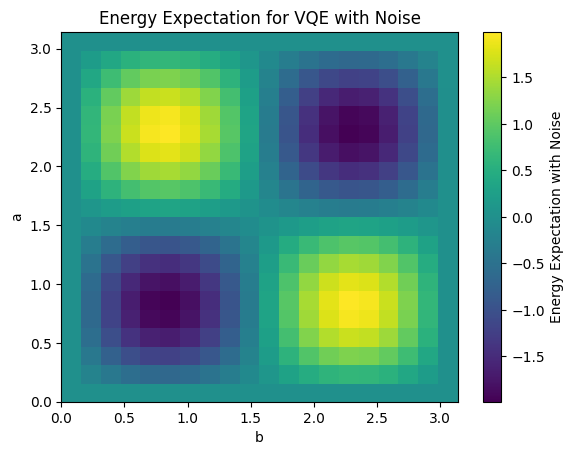

Minimum energy with noise: -1.9863613034027208 at a = 0.8267349088394192, b = 0.8267349088394192


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer.noise import NoiseModel, amplitude_damping_error, depolarizing_error
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

# Define the Hamiltonian
H = SparsePauliOp.from_list([("XZ", -1), ("ZX", -1)])


# Prepare the grid search parameters
nmbr_points = 20
a_array = np.linspace(0, np.pi, nmbr_points)
b_array = np.linspace(0, np.pi, nmbr_points)
expectation_value_noisy = np.zeros((nmbr_points, nmbr_points))

# Backend setup
backend = AerSimulator()

# Define the noise model
p = 0.2
gamma = 0.1
noise_model = NoiseModel()
single_qubit_error = amplitude_damping_error(gamma, p)
two_qubit_error = depolarizing_error(0.01, 2)
noise_model.add_all_qubit_quantum_error(single_qubit_error, ['rz'])
noise_model.add_all_qubit_quantum_error(single_qubit_error, ['h'])
noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])

# Estimator with noise model
estimator = Estimator()

# Evaluate the energy expectation for each parameter set with noise
for a_id, a_val in enumerate(a_array):
    for b_id, b_val in enumerate(b_array):
        psi = parametrized_circuit(a_val, b_val)
        transpiled_psi = transpile(psi, backend)
        # Run the transpiled circuit on the backend with noise model
        result = estimator.run(transpiled_psi, H, noise_model=noise_model, backend_options={"backend_name": "aer_simulator"}).result()
        expectation_value_noisy[a_id, b_id] = result.values[0]

# Plot the heatmap with noise
plt.imshow(expectation_value_noisy, origin='lower', extent=[0, np.pi, 0, np.pi], aspect='auto', cmap='viridis')
plt.colorbar(label='Energy Expectation with Noise')
plt.title('Energy Expectation for VQE with Noise')
plt.xlabel('b')
plt.ylabel('a')
plt.show()

# Find the minimum energy state with noise
min_index_noisy = np.unravel_index(np.argmin(expectation_value_noisy), expectation_value_noisy.shape)
min_energy_noisy = expectation_value_noisy[min_index_noisy]
min_a_noisy = a_array[min_index_noisy[0]]
min_b_noisy = b_array[min_index_noisy[1]]

print(f"Minimum energy with noise: {min_energy_noisy} at a = {min_a_noisy}, b = {min_b_noisy}")